In [324]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

!pip install -q catboost shap category_encoders pmdarima neuralprophet
!pip install -qU statsmodels

clear_output()

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# we may use PowerTranformer or other non-linear scalers, but they would eliminate 
# needed correlations between variables, that are very helpful in linear models
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputRegressor  # in case we will use boosting models in TS
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report

# generating is actually not needed due to partitionally working with TS
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from catboost import CatBoostRegressor, Pool, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm

from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX  # in case LinearRegression won't fit well
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

import category_encoders as ce

np.random.seed(123)

In [3]:
data_root = r'/content/drive/My Drive/data/weather/rain.csv'
TARGET_NAME_REG = 'RISK_MM'
TARGET_NAME_CLS = 'RainTomorrow'

In [4]:
location_mapping =  {'Adelaide': 0, 'Albany': 0, 'Albury': 0, 'AliceSprings': 1,
                    'BadgerysCreek': 0, 'Ballarat': 0, 'Bendigo': 0, 'Brisbane': 2,
                    'Cairns': 3, 'Canberra': 0, 'Cobar': 4, 'CoffsHarbour': 2,
                    'Dartmoor': 0, 'Darwin': 3, 'GoldCoast': 2, 'Hobart': 0, 'Katherine': 3,
                    'Launceston': 0, 'Melbourne': 0, 'MelbourneAirport': 0, 'Mildura': 4,
                    'Moree': 2, 'MountGambier': 0, 'MountGinini': 0, 'Newcastle': 0, 'Nhil': 4,
                    'NorahHead': 0, 'NorfolkIsland': 2, 'Nuriootpa': 0, 'PearceRAAF': 2,
                    'Penrith': 0, 'Perth': 2, 'PerthAirport': 2, 'Portland': 0, 'Richmond': 0,
                    'Sale': 0, 'SalmonGums': 4, 'Sydney': 0, 'SydneyAirport': 0, 'Townsville': 3,
                    'Tuggeranong': 0, 'Uluru': 1, 'WaggaWagga': 0, 'Walpole': 0, 'Watsonia': 0,'Williamtown': 0, 
                    'Witchcliffe': 0, 'Wollongong': 0, 'Woomera': 1}
# we will need these mapping to obtain information about rain in nearby regions

In [5]:
def regression_results(y_true, y_pred):
    mae=mean_absolute_error(y_true, y_pred) 
    mse=mean_squared_error(y_true, y_pred) 
    r2=r2_score(y_true, y_pred)
    print('r2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

def report(y_train, y_train_pred, y_test, y_test_pred):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        return X[self.columns]

class Fourier(BaseEstimator, TransformerMixin):
    def __init__(self, season="A", order=2):
        self.fourier = CalendarFourier(freq=season, order=order)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        dp = DeterministicProcess(
            index=X_.index,
            constant=True,               # dummy feature for bias (y-intercept)
            order=1,                     # trend (order 1 means linear)
            seasonal=True,               # weekly seasonality (indicators)
            additional_terms=[self.fourier],  # annual seasonality (fourier)
            drop=True,                   # drop terms to avoid collinearity
        )
        X_ = dp.in_sample() 
        return X_

class RollingWindow(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=3, method=None):
        self.method = method
        self.window_size = window_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        roll_exp = X['RISK_MM'].ewm(span=self.window_size, adjust=False).mean()
        weights = np.arange(1,self.window_size+1)
        roll_w = X['RISK_MM'].rolling(self.window_size).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
        roll_ = X['RISK_MM'].rolling(window=self.window_size).mean()
        return pd.concat([roll_exp, roll_w, roll_], axis=1)

class LagFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_lags=2):
        self.n_lags = n_lags

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.make_lags(X, self.n_lags)

    @staticmethod
    def make_lags(ts, lags, lead_time=1):
        return pd.concat(
            {
                f'y_lag_{i}': ts.shift(i)
                for i in range(lead_time, lags + lead_time)
            },
            axis=1)
        
class FeatureInterpolator(BaseEstimator, TransformerMixin):
    def __init__(self, method='from_derivatives'):
        self.method = method

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        return X_.interpolate(method=self.method, axis=0)

class DataFrameR(BaseEstimator, TransformerMixin):
    def __init__(self, columns, index=None):
        self.columns = columns
        self.index = index

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert len(self.columns) == X.shape[1], f'Number of columns {len(self.columns)} is not equal to data shape {X.shape[1]}'
        if self.index is not None:
            X_ = pd.DataFrame(X, columns=self.columns, index=self.index)
        else:
            X_ = pd.DataFrame(X, columns=self.columns)
        return X_

In [7]:
df = pd.read_csv(data_root)
df.Date = pd.to_datetime(df.Date, format="%d/%m/%Y")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [15]:
df.describe()
# maybe not so much significant outliers, as there might be lots of sunny hot weather and rare storms
# with high speed wind and huge amount of rainfall

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


For simplicity lets assume next:



1.   Take only one location first
2.   For this location fill del (e.g. Evaporation, Sunshine) and fill nans with IterativeImputer, SimpleImputer, Interpolate in slice of rain-no_rain
3. Do not remove outliers as they are not so extreme and may contain important information
4. Inspect given subdataset on TS components
5. Create additional variable, that contains information about whether it is raining in nearby locations today
6. Predict RISK_MM for test subdataset using Sarimax outside Pipeline and TS features (NOTE: scale numeric columns, encode categorical columns with category_encoders)
6. Create LogisticRegression for output dataset (that contains initial features for chosen location and predicted RISK_MM)
8. Predict rain labels for given location
9. Stack all results from all locations to the final submission

NOTE: common models can only predict one time step in future. We can use LinearRegression for multistep forecast, but only those amount of steps that we have known target (to create lags, etc.). This is not what we want. As we want to predict all targets at once, assuming we have train set and forecast all the test set! 

Firstly, I made such perdictions with obvious target leakage! Of course I got perfect results. But then I found out that awful mistake and decided to use SARIMA... As it can provide better results than LinearRegression and predict given big forecast horizon.



In [355]:
# select Canberra as it contains the highest amount of observations
can = df[df.Location == 'Canberra'].sort_values(by='Date')

In [23]:
can.describe(include=['object'])

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,3418,3089,2882,3190,3402,3418
unique,1,16,16,16,2,2
top,Canberra,NW,NNW,NW,No,No
freq,3418,601,340,596,2778,2789


In [356]:
# firstly we are going to predict RISK_MM and after when we get it we will resplit dataset with stratify option
X, y = can.drop([TARGET_NAME_REG, TARGET_NAME_CLS, 'Location'], axis=1), can[TARGET_NAME_REG]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=123)
X_train.shape, X_test.shape

((2734, 21), (684, 21))

In [357]:
X_train_tar = pd.concat([X_train, y_train], axis=1)
X_test_tar = pd.concat([X_test, y_test], axis=1)

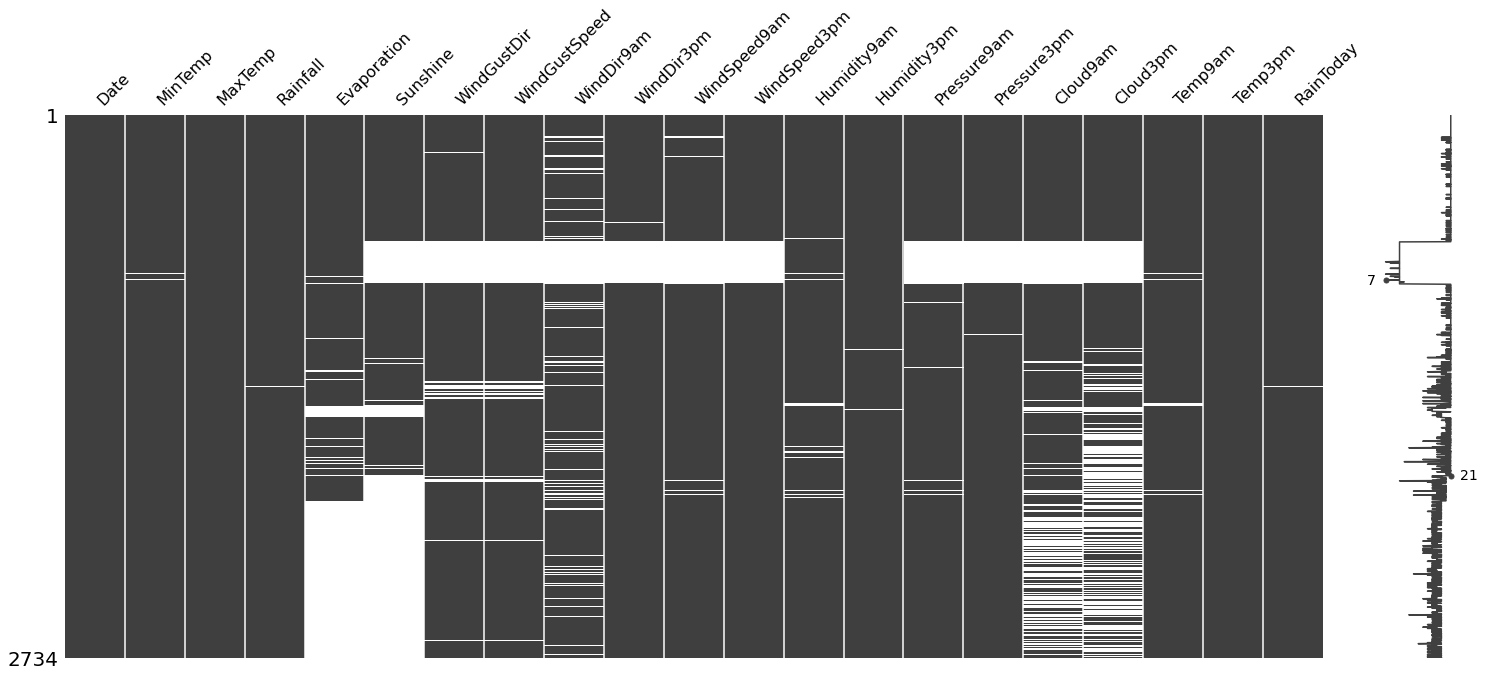

In [28]:
import missingno as msn

msn.matrix(X_train)
# better drop Sunshine, Evaporation, Cloud9am, Cloud3pm or just do not select them in Pipeline

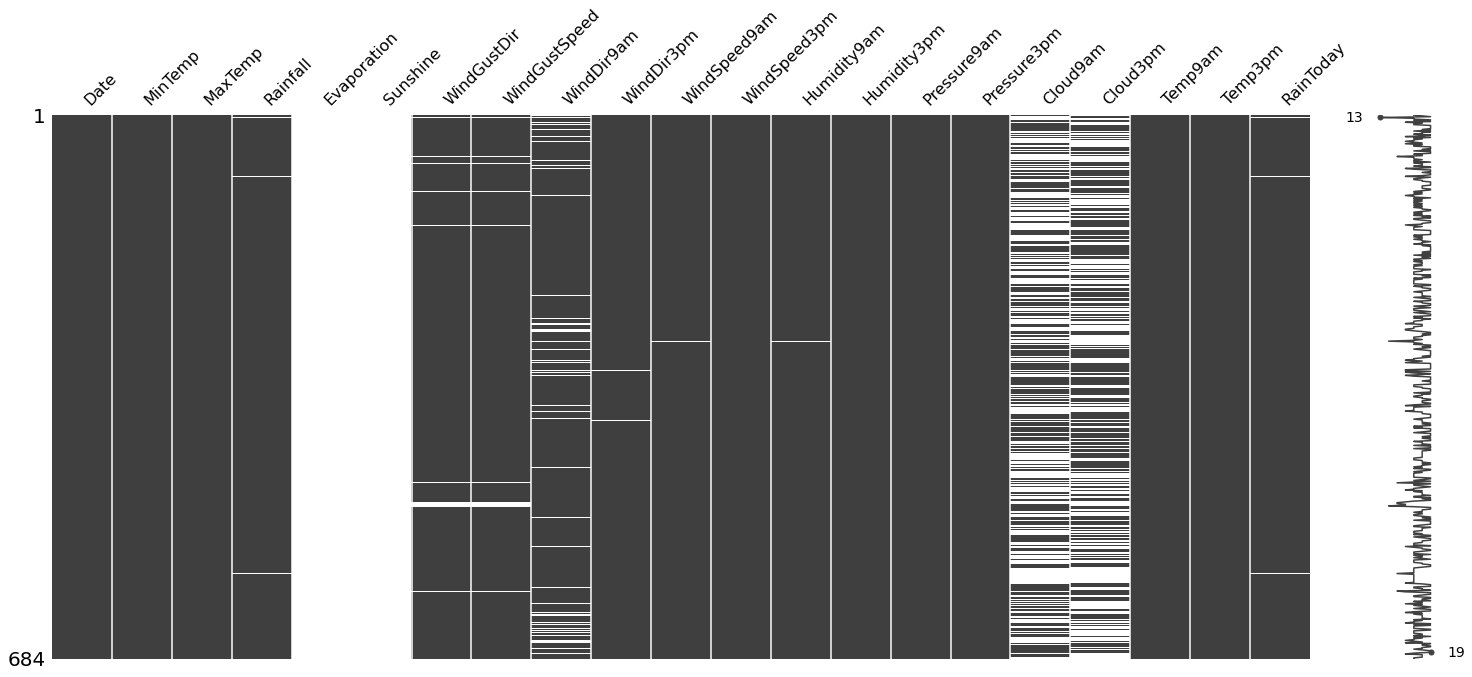

In [38]:
msn.matrix(X_test)

In [61]:
X_train.isna().sum()
# we may interpolate missing values in columns with few nans
# and impute where there are lots of nans

Date                0
MinTemp             5
MaxTemp             3
Rainfall           12
Evaporation       911
Sunshine         1222
WindGustDir       313
WindGustSpeed     311
WindDir9am        476
WindDir3pm        225
WindSpeed9am      227
WindSpeed3pm      222
Humidity9am        60
Humidity3pm        12
Pressure9am       224
Pressure3pm       220
Cloud9am          722
Cloud3pm          927
Temp9am            17
Temp3pm             7
RainToday          12
dtype: int64

In [358]:
cols_to_interpolate = ['Temp3pm', 'Temp9am', 'Humidity3pm', 'Humidity9am', 'Rainfall', 'MaxTemp', 'MinTemp']
target_col = ['RISK_MM',]
cols_to_iter_impute = ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']
binary_enc_cols = ['RainToday',]
target_enc_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [ ]:
# TS inspection for RISK_MM

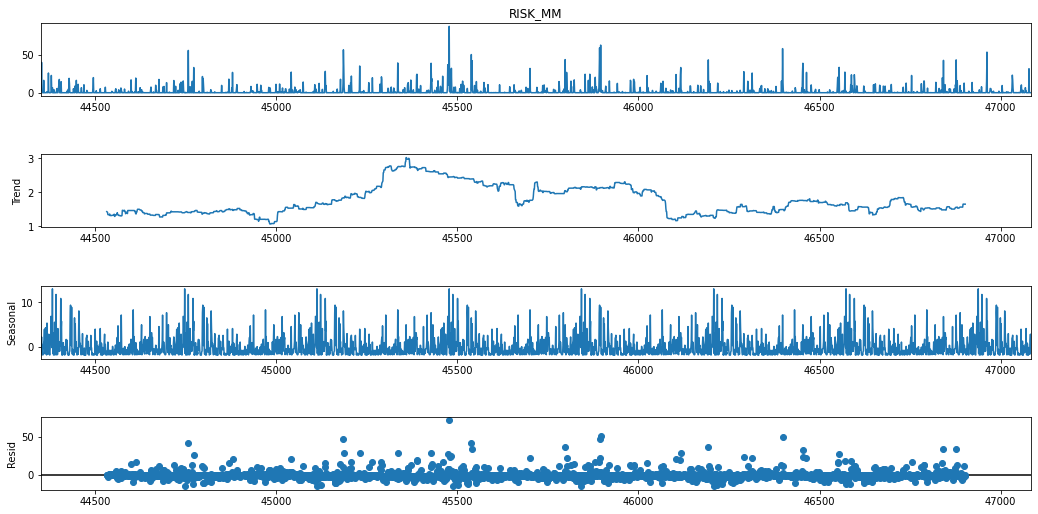

In [43]:
decompose = seasonal_decompose(X_train_tar['RISK_MM'], model='additive', period=365)
fig = decompose.plot()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.show()

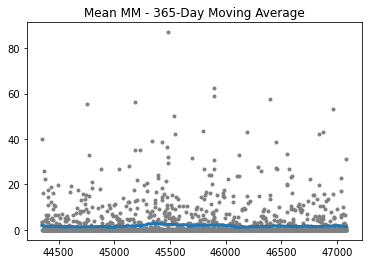

In [46]:
moving_average = X_train_tar['RISK_MM'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = X_train_tar['RISK_MM'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Mean MM - 365-Day Moving Average", legend=False,
);
# no significant trend

In [47]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [48]:
train_ = X_train_tar.set_index('Date').to_period('D')

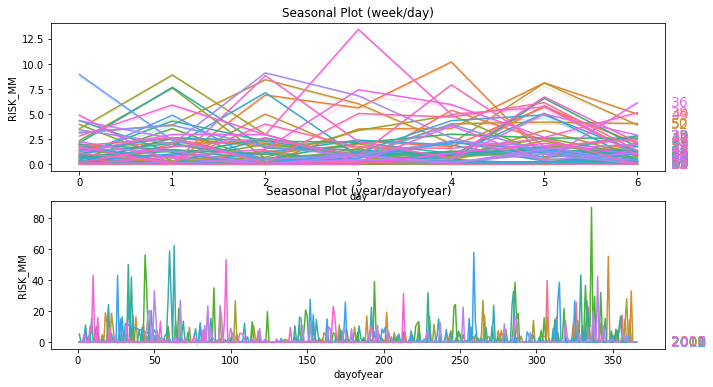

In [53]:
X_ = train_.copy()

# days within a week
X_["day"] = train_.index.dayofweek  # the x-axis (freq)
X_["week"] = train_.index.week  # the seasonal period (period)

# days within a year
X_["dayofyear"] = train_.index.dayofyear
X_["year"] = train_.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X_, y="RISK_MM", period="week", freq="day", ax=ax0)
seasonal_plot(X_, y="RISK_MM", period="year", freq="dayofyear", ax=ax1);

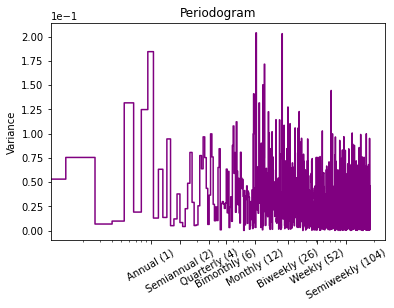

In [55]:
plot_periodogram(X_train_tar['RISK_MM'])  # cannot obtain any seasonality



1.   Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
2.   Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. It's charachteristics are constant in time.

In [58]:
dftest = adfuller(X_train_tar['RISK_MM'], autolag='AIC', regression=None)
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], dftest))
# the data is stationary

{'adf': -16.678728300230368,
 'criticalvalues': {'1%': -2.5665673451723943,
  '10%': -1.6167221450551865,
  '5%': -1.9410997929668397},
 'icbest': 17159.53062160489,
 'nobs': 2704,
 'pvalue': 2.640350464226106e-28,
 'usedlag': 28}

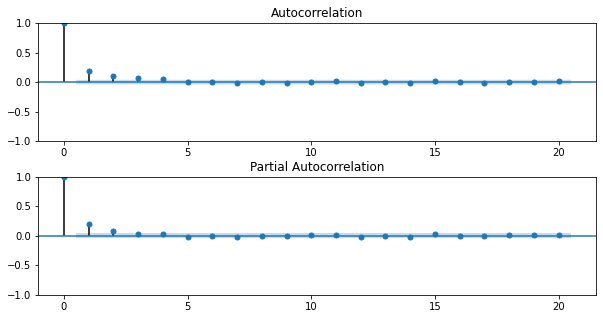

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(X_train_tar['RISK_MM'], lags=20, ax=ax[0])
fig = plot_pacf(X_train_tar['RISK_MM'], lags=20, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()
# we will use two lags

In [12]:
# add FEATURE
df.RainToday = df.RainToday.map({'No': 0, 'Yes': 1})

In [256]:
# add new variable that contains information about rain in neighbor's locations
near_locations = [key for key, val in location_mapping.items() if location_mapping[key] == location_mapping.get('Canberra')]

df_to_merge = pd.DataFrame(data=X[['Date', 'RainToday']], columns=['Date', 'RainToday'])
df_to_merge['RainToday'] = df_to_merge['RainToday'].map({'No': 0, 'Yes': 1})
for location in near_locations:
    temp_df = df[df.Location == location][['Date', 'RainToday']]
    df_to_merge = df_to_merge.merge(temp_df, on=['Date'], how='left')
df_to_merge.fillna(0., inplace=True)
df_to_merge.sort_values('Date', inplace=True)
df_to_merge['Sum_near_locs'] = df_to_merge.iloc[:, 1:].sum(axis=1)
df_to_merge = df_to_merge[['Date', 'Sum_near_locs']]

In [359]:
# merging new var with train and test datasets
X_train_tar = X_train_tar.merge(df_to_merge, on='Date', how='left')
X_test_tar = X_test_tar.merge(df_to_merge, on='Date', how='left')
cols_to_iter_impute += ['Sum_near_locs', ]

In [360]:
# binary encoding of one column is not nessasary inside pipeline
X_train_tar['RainToday'] = X_train_tar['RainToday'].map({'No': 0, 'Yes': 1})
X_test_tar['RainToday'] = X_test_tar['RainToday'].map({'No': 0, 'Yes': 1})

In [361]:
# setting date column as index
X_train_tar.set_index('Date', drop=True, inplace=True)
X_test_tar.set_index('Date', drop=True, inplace=True)

In [362]:
cols_to_interpolate = ['Temp3pm', 'Temp9am', 'Humidity3pm', 'Humidity9am', 'Rainfall', 'MaxTemp', 'MinTemp']
target_col = ['RISK_MM',]
cols_to_iter_impute = ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm', 
                       'RainToday', 'Sum_near_locs']
target_enc_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [363]:
y_train.index = X_train_tar.index

#to_concat = X_train_tar.iloc[-2:, :]
#X_test_tar = pd.concat([to_concat, X_test_tar], axis=0)

In [364]:
# defining pipelines

enc_pipe = Pipeline(steps=[('selector1', ColumnSelector(target_enc_cols)),
                           ('imputer1', SimpleImputer(strategy='most_frequent')),
                           ('encoder1', ce.cat_boost.CatBoostEncoder()),
                           ])

interp_pipe = Pipeline(steps=[('selector2', ColumnSelector(cols_to_interpolate)),
                              ('iterpol', FeatureInterpolator()),])

rolling_pipe = Pipeline(steps=[('selector3', ColumnSelector(target_col)),
                               ('rolling', RollingWindow())])

lag_pipe = Pipeline(steps=[('selector4', ColumnSelector(target_col)),
                           ('lags', LagFeatures())])

union = FeatureUnion(transformer_list=[('enc_pipe', enc_pipe), # 3
                                       ('interp', interp_pipe), # 7
                                       #('roll', rolling_pipe), # 3 - target leakage
                                       #('lag', lag_pipe), # 2 - target leakage
                                       ('imp_cols', ColumnSelector(cols_to_iter_impute))]) # 7

X_train_tar_ = union.fit_transform(X_train_tar, y_train)
X_test_tar_ = union.transform(X_test_tar)

#X_train_tar_ = X_train_tar_[2:, :]
#X_test_tar_ = X_test_tar_[2:, :]

X_train_tar_ = pd.DataFrame(data=X_train_tar_, columns=[f'ft_{i+1}' for i in range(X_train_tar_.shape[1])], index=X_train_tar.index)#[2:])
X_test_tar_ = pd.DataFrame(data=X_test_tar_, columns=[f'ft_{i+1}' for i in range(X_test_tar_.shape[1])], index=X_test_tar.index)#[2:])
#cols_to_scale = [col for col in X_train_tar_.columns.tolist() if col != 'ft_21']

scaler = MinMaxScaler()  # RobustScaler()
#X_train_tar_[cols_to_scale] = scaler.fit_transform(X_train_tar_[cols_to_scale])
#X_test_tar_[cols_to_scale] = scaler.transform(X_test_tar_[cols_to_scale])
X_train_tar_.iloc[:,:] = scaler.fit_transform(X_train_tar_.iloc[:,:])
X_test_tar_.iloc[:,:] = scaler.transform(X_test_tar_.iloc[:,:])

# cannot use intercepted columns in ColumnTransformer as if it stacks all transformers results
column_trans_pipe = ColumnTransformer(transformers=[
                                                    ('imputation', IterativeImputer(random_state=123), X_train_tar_.columns.tolist())], 
                                      )

X_train_tar_ = column_trans_pipe.fit_transform(X_train_tar_, y_train)
X_test_tar_ = column_trans_pipe.transform(X_test_tar_)

X_train_tar_ = pd.DataFrame(data=X_train_tar_, columns=[f'ft_{i+1}' for i in range(X_train_tar_.shape[1])], index=X_train_tar.index)#[2:])
X_test_tar_ = pd.DataFrame(data=X_test_tar_, columns=[f'ft_{i+1}' for i in range(X_test_tar_.shape[1])], index=X_test_tar.index)#[2:])
#y_train_tar_ = y_train[2:]

y_test.index = X_test_tar_.index

X_train_tar_.shape, y_train.shape, X_test_tar_.shape, y_test.shape

((2734, 16), (2734,), (684, 16), (684,))

In [ ]:
# NEXT code cells provide a way for multioutput forecast

In [233]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
    
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

X = make_lags(y, lags=4).fillna(0.0)

y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)


In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [235]:
model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [236]:
regression_results(y_test, y_pred)

r2:  -0.0029
MAE:  2.6534
MSE:  28.2418
RMSE:  5.3143


In [243]:
y_pred

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
46909,1.242501,1.480393,1.604596,1.690743,1.770613,1.782967,1.789516,1.753673
46910,1.242501,1.480393,1.604596,1.690743,1.770613,1.782967,1.789516,1.753673
46911,1.276163,1.500544,1.616514,1.702771,1.770945,1.785846,1.786150,1.752916
46912,1.256813,1.488905,1.614328,1.689019,1.773381,1.779176,1.789405,1.751455
46913,1.584859,1.690179,1.720728,1.812871,1.770001,1.811563,1.754048,1.747455
...,...,...,...,...,...,...,...,...
47757,1.281905,1.508818,1.613466,1.704613,1.767011,1.785657,1.784344,1.754269
47758,1.296967,1.505404,1.626804,1.696620,1.773244,1.780462,1.787882,1.752914
47759,1.296217,1.517330,1.623199,1.702888,1.769779,1.781866,1.784233,1.752051
47760,1.269048,1.493526,1.611839,1.686432,1.768978,1.777396,1.789444,1.755024


In [ ]:
# ENDS here

In [222]:
# result with obvious target leakage
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_tar_, y_train_tar_)

pred = lr.predict(X_test_tar_)

regression_results(y_test, pred)

r2:  1.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0


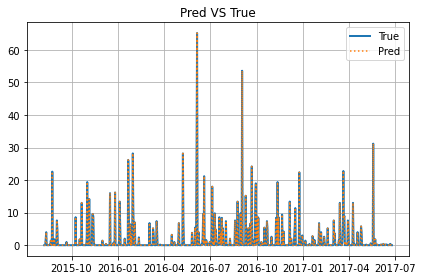

In [156]:
pred = pd.Series(data=pred, name='RISK_MM', index=y_test.index)
plt.title('Pred VS True')

plt.plot(y_test, label='True', lw=2)
plt.plot(pred, label='Pred', lw=1.5, ls=':')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# we'll try to use SARIMAX to fix the target leakage

In [338]:
X_train_tar_.index = pd.DatetimeIndex(X_train_tar_.index).to_period('D')
X_test_tar_.index = pd.DatetimeIndex(X_test_tar_.index).to_period('D')
y_train.index = y_train.index = pd.DatetimeIndex(y_train.index).to_period('D')
y_test.index = pd.DatetimeIndex(y_test.index).to_period('D')

In [339]:
step_wise = auto_arima(y_train, exogenous=X_train_tar_, 
                       start_p=1, start_q=1,  
                       max_p=7, max_q=7,  d=0, max_d=1, 
                       trend='ct', trace=True, 
                       error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16595.182, Time=7.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16581.424, Time=2.50 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16580.625, Time=5.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16581.147, Time=12.81 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16581.424, Time=2.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=16569.057, Time=7.40 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=16564.673, Time=6.85 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=16560.494, Time=8.19 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=16561.264, Time=9.17 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=16562.435, Time=4.57 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=16566.796, Time=6.61 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=16563.265, Time=5.62 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=16560.494, Time=7.68 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 86.854 seconds


In [340]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2734
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -8257.247
Date:                Sat, 12 Mar 2022   AIC                          16560.494
Time:                        22:16:04   BIC                          16696.505
Sample:                    11-01-2007   HQIC                         16609.648
                         - 08-07-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0209      1.182     -0.018      0.986      -2.337       2.295
drift      -1.042e-05      0.000     -0.066      0.948      -0.000       0.000
ft_1          -0.0816      1.703     -0.048      0.962      -3.420       3.257
ft_2           0.4224      1.893      0.223      0.823      -3.287       4.132
ft_3          -0.6170      1.696     -0.364      0.716      -3.940       2.706
ft_4          -0.1485      2.765     -0.054      0.957      -5.568       5.271
ft_5           5.6964      3.122      1.825      0.068      -0.422      11.815
ft_6          13.2375      1.264     10.474      0.000      10.761      15.715
ft_7          -3.0933      1.326     -2.332      0.020      -5.693      -0.494
ft_8           6.3181      3.560      1.775      0.076      -0.659      13.295
ft_9          -4.2223      2.381     -1.773      0.076      -8.889       0.444
ft_10         -0.0859      1.895     -0.045      0.964      -3.799       3.627
ft_11         12.0727      0.847     14.258      0.000      10.413      13.732
ft_12         -6.7996      1.017     -6.684      0.000      -8.793      -4.806
ft_13         -8.0586      0.795    -10.137      0.000      -9.617      -6.500
ft_14         26.5804      3.965      6.704      0.000      18.809      34.352
ft_15        -31.2898      3.647     -8.579      0.000     -38.438     -24.142
ft_16          1.5214      0.660      2.306      0.021       0.228       2.814
ar.L1          0.0245      0.043      0.564      0.572      -0.061       0.109
ar.L2          0.0641      0.012      5.528      0.000       0.041       0.087
ar.L3          0.0476      0.011      4.411      0.000       0.026       0.069
ar.L4          0.0473      0.015      3.214      0.001       0.018       0.076
sigma2        24.3750      0.289     84.469      0.000      23.809      24.941
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            298224.67
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             5.39
Prob(H) (two-sided):                  0.02   Kurtosis:                        53.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [341]:
sarima = SARIMAX(y_train, exog=X_train_tar_, order=(4,0,0), seasonal_order=(0, 0, 0, 0), 
                 enforce_invertibility=False, enforce_stationarity=False)
results = sarima.fit()

In [343]:
pred = results.predict(start=X_train_tar_.shape[0], end=X_train_tar_.shape[0] + X_test_tar_.shape[0] - 1, exog=X_test_tar_)

In [345]:
regression_results(y_test, np.abs(pred))

r2:  0.3483
MAE:  2.3052
MSE:  17.8893
RMSE:  4.2296


In [346]:
from neuralprophet import NeuralProphet

In [395]:
data_train = pd.DataFrame(data={'ds': y_train.index, 'y': y_train.values})
data_test = pd.DataFrame(data={'ds': y_test.index, 'y': y_test.values})

model = NeuralProphet(
                      n_forecasts=X_test_tar_.shape[0],
                      n_lags=4,
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      batch_size=4,
                      epochs=100,
                      learning_rate=0.01,
)



In [397]:
model = NeuralProphet()
#for col in X_train_tar_.columns:
#    model.add_future_regressor(col, normalize='auto')

metrics = model.fit(data_train, freq='D', validation_df=data_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.415% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 89


  0%|          | 0/271 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.01E-02, min: 7.94E-01


  0%|          | 0/271 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.01E-02, min: 1.47E+00


  0%|          | 0/271 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.01E-02, min: 1.85E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.01E-02
Epoch[89/89]: 100%|██████████| 89/89 [00:16<00:00,  5.53it/s, SmoothL1Loss=0.0877, MAE=2.43, RMSE=4.96, RegLoss=0, MAE_val=2.4, RMSE_val=5.28, SmoothL1Loss_val=0.0773]


In [391]:
future = model.make_future_dataframe(data_train[['ds', 'y']], periods=len(data_test), n_historic_predictions=len(data_train))
prediction = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.415% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.532% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.532% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [393]:
regression_results(y_test, prediction.yhat1[-len(data_test):])

r2:  -0.016
MAE:  2.3763
MSE:  27.8883
RMSE:  5.2809


In [309]:
X, y = can.drop([TARGET_NAME_CLS, 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1), can[TARGET_NAME_CLS]
#X['RainToday'] = X['RainToday'].map({'No': 0, 'Yes': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=123)
X_test[TARGET_NAME_REG] = np.abs(pred.values)
y_train = y_train.map({'No': 0, 'Yes': 1})
y_test = y_test.map({'No': 0, 'Yes': 1})

In [310]:
X_train.set_index('Date', drop=True, inplace=True)
X_test.set_index('Date', drop=True, inplace=True)

In [311]:
y_train.index = X_train.index
y_test.index = X_test.index

In [312]:
cols_to_interpolate = ['Temp3pm', 'Temp9am', 'Humidity3pm', 'Humidity9am', 'Rainfall', 'MaxTemp', 'MinTemp']
cols_to_iter_impute = ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm', 'RainToday',
                       'RISK_MM']
target_enc_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [313]:
enc_pipe = Pipeline(steps=[('selector1', ColumnSelector(target_enc_cols)),
                           ('imputer1', SimpleImputer(strategy='most_frequent')),
                           ('encoder1', ce.cat_boost.CatBoostEncoder()),
                           ])

interp_pipe = Pipeline(steps=[('selector2', ColumnSelector(cols_to_interpolate)),
                              ('iterpol', FeatureInterpolator()),])


union = FeatureUnion(transformer_list=[('enc_pipe', enc_pipe), # 3
                                       ('interp', interp_pipe), # 7
                                       ('imp_cols', ColumnSelector(cols_to_iter_impute))]) # 8

pipe = Pipeline(steps=[('union', union),
                       ('imputer', IterativeImputer(random_state=123)),
                       ('scaler', RobustScaler())])

X_train_ = pipe.fit_transform(X_train, y_train)
X_test_ = pipe.fit_transform(X_test, y_test)

X_train_ = pd.DataFrame(data=X_train_, columns=X_train.columns.tolist(), index=X_train.index)
X_test_ = pd.DataFrame(data=X_test_, columns=X_test.columns.tolist(), index=X_test.index)


In [204]:
y_train.value_counts(normalize=True)

0    0.818581
1    0.181419
Name: RainTomorrow, dtype: float64

In [314]:
log_reg = LogisticRegression(penalty='l2', 
                             C=.1, 
                             class_weight='balanced', 
                             random_state=123, 
                             solver='lbfgs', 
                             max_iter=200)
log_reg.fit(X_train_, y_train)

train_pred = log_reg.predict(X_train_)
test_pred = log_reg.predict(X_test_)

report(y_train, train_pred, y_test, test_pred)

Train
               precision    recall  f1-score   support

           0      1.000     0.993     0.997      2238
           1      0.971     1.000     0.985       496

    accuracy                          0.995      2734
   macro avg      0.985     0.997     0.991      2734
weighted avg      0.995     0.995     0.995      2734

Test
               precision    recall  f1-score   support

           0      0.807     1.000     0.893       551
           1      1.000     0.008     0.015       133

    accuracy                          0.807       684
   macro avg      0.903     0.504     0.454       684
weighted avg      0.844     0.807     0.722       684

Confusion Matrix 
 col_0           0  1
RainTomorrow        
0             551  0
1             132  1
